<a href="https://colab.research.google.com/github/Zibraan/My_ML_DL_Codes/blob/main/ML_Assesment_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================================================================
# Time-Series Forecasting for Household Energy Consumption Using Machine Learning Models Setup and Data Loading
# ==============================================================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For nicer plots
plt.style.use("seaborn-v0_8")
sns.set()

# 1.1 Load the dataset (upload to Colab first, then use the exact filename)
file_path = "household_power_consumption.txt"

df_raw = pd.read_csv(
    file_path,
    sep=";",
    low_memory=False
)

print("Raw shape:", df_raw.shape)
df_raw.head()

Raw shape: (1205412, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
# ==========================================
# 2. Preprocessing: datetime and cleaning
# ==========================================

# 2.1 Combine Date and Time into a single datetime column
df = df_raw.copy()
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S",
    errors="coerce"
)

# Drop rows where datetime parsing failed
df = df.dropna(subset=["datetime"])

# 2.2 Set datetime as index and sort
df = df.set_index("datetime").sort_index()

# 2.3 Convert numeric columns to float
num_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3"
]

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 2.4 Handle missing values
print("Missing values before:", df[num_cols].isna().sum())

# Strategy: drop rows with missing target (Global_active_power),
# and forward-fill others for simplicity
df = df.dropna(subset=["Global_active_power"])
df[num_cols] = df[num_cols].ffill()

print("Missing values after:", df[num_cols].isna().sum())

# 2.5 Remove duplicate timestamps if any
df = df[~df.index.duplicated(keep="first")]

df.head()


Missing values before: Global_active_power      4137
Global_reactive_power    4137
Voltage                  4137
Global_intensity         4137
Sub_metering_1           4137
Sub_metering_2           4137
Sub_metering_3           4137
dtype: int64
Missing values after: Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
# ===================================================
# 3. Resample to hourly and engineer time features
# ===================================================

# Drop non-numeric columns that are no longer needed before resampling
df = df.drop(columns=["Date", "Time"])

# 3.1 Resample to hourly mean
df_hourly = df.resample("H").mean()  # mean power per hour

print("Hourly shape:", df_hourly.shape)
df_hourly.head()

# 3.2 Create time-based features
df_hourly["hour"] = df_hourly.index.hour
df_hourly["day_of_week"] = df_hourly.index.dayofweek
df_hourly["day_of_month"] = df_hourly.index.day
df_hourly["month"] = df_hourly.index.month

# Optionally, cyclic encoding (comment out if you want simple ints)
df_hourly["hour_sin"] = np.sin(2 * np.pi * df_hourly["hour"] / 24)
df_hourly["hour_cos"] = np.cos(2 * np.pi * df_hourly["hour"] / 24)
df_hourly["dow_sin"] = np.sin(2 * np.pi * df_hourly["day_of_week"] / 7)
df_hourly["dow_cos"] = np.cos(2 * np.pi * df_hourly["day_of_week"] / 7)

df_hourly.head()

Hourly shape: (20091, 7)


/tmp/ipython-input-2566804942.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample("H").mean()  # mean power per hour


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,day_of_month,month,hour_sin,hour_cos,dow_sin,dow_cos
datetime,,,,,,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17,5,16,12,-0.965926,-2.588190e-01,-0.974928,-0.222521
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,18,5,16,12,-1.000000,-1.836970e-16,-0.974928,-0.222521
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,19,5,16,12,-0.965926,2.588190e-01,-0.974928,-0.222521
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,20,5,16,12,-0.866025,5.000000e-01,-0.974928,-0.222521
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,21,5,16,12,-0.707107,7.071068e-01,-0.974928,-0.222521


count    20029.000000
mean         1.131068
std          0.965490
min          0.124000
25%          0.318067
50%          0.820267
75%          1.652233
max          6.560533
Name: Global_active_power, dtype: float64


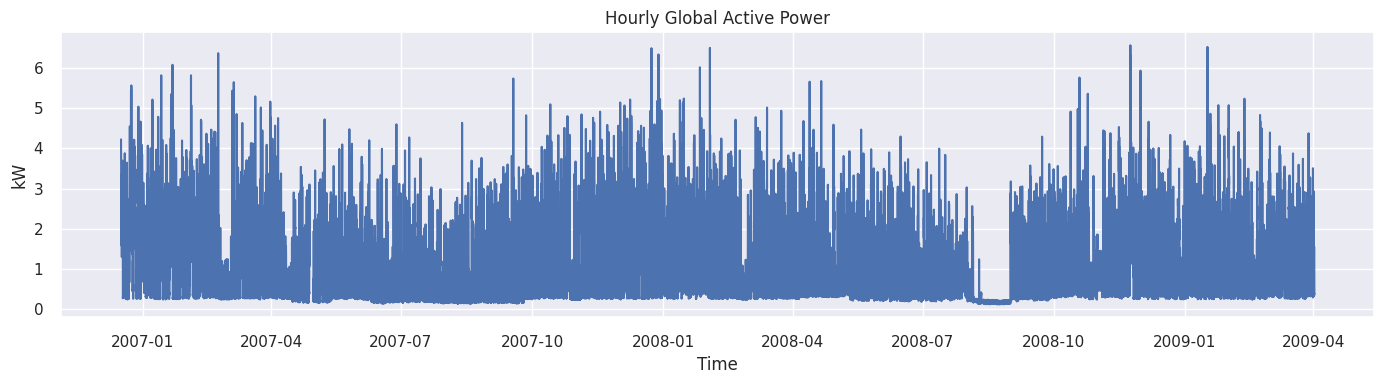

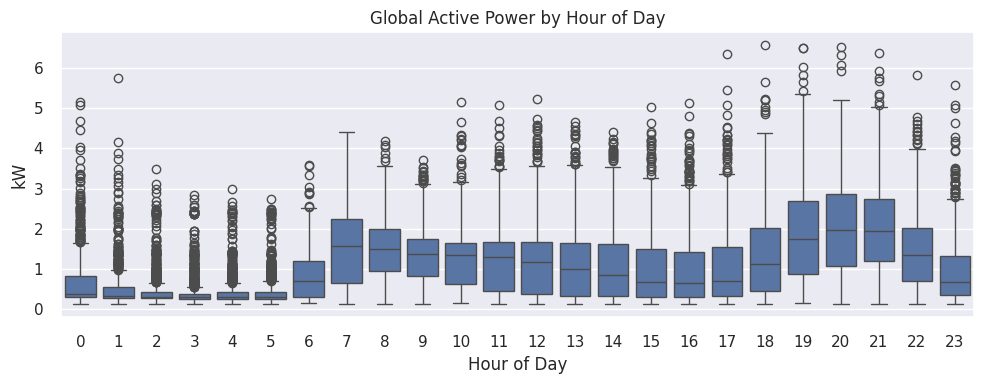

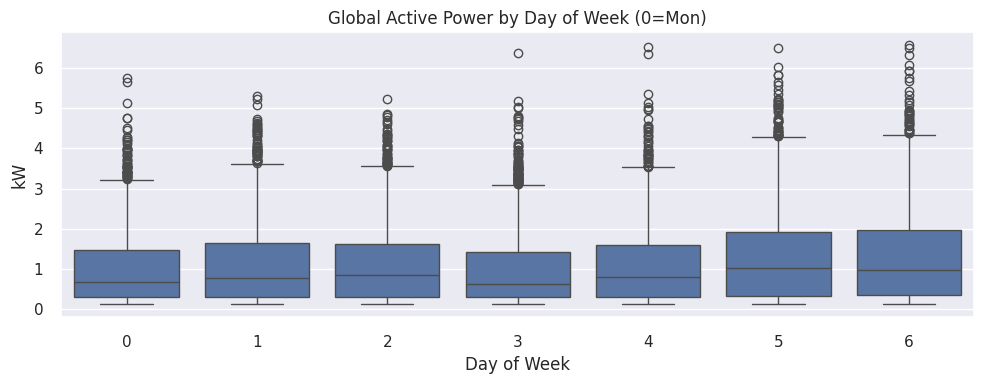

In [ ]:
# ===============================
# 4. Exploratory Data Analysis
# ===============================

target_col = "Global_active_power"

# 4.1 Basic statistics
print(df_hourly[target_col].describe())

# 4.2 Time series plot (for the available subset)
plt.figure(figsize=(14, 4))
plt.plot(df_hourly.index, df_hourly[target_col])
plt.title("Hourly Global Active Power")
plt.ylabel("kW")
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# 4.3 Boxplot by hour of day
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_hourly["hour"], y=df_hourly[target_col])
plt.title("Global Active Power by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("kW")
plt.tight_layout()
plt.show()

# 4.4 Boxplot by day of week
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_hourly["day_of_week"], y=df_hourly[target_col])
plt.title("Global Active Power by Day of Week (0=Mon)")
plt.xlabel("Day of Week")
plt.ylabel("kW")
plt.tight_layout()
plt.show()


In [ ]:
# ======================================================
# 5. Create lag features and train/test split
# ======================================================

# 5.1 Create lag features for the target
max_lag = 24  # lags up to 24 hours
for lag in [1, 2, 3, 24]:
    df_hourly[f"lag_{lag}"] = df_hourly[target_col].shift(lag)

# 5.2 Drop rows with NaNs from lags
df_model = df_hourly.dropna(subset=[target_col] + [f"lag_{lag}" for lag in [1, 2, 3, 24]])

# 5.3 Define features and target
feature_cols = [
    "lag_1", "lag_2", "lag_3", "lag_24",
    "hour", "day_of_week", "day_of_month", "month",
    "hour_sin", "hour_cos", "dow_sin", "dow_cos"
]

X = df_model[feature_cols]
y = df_model[target_col]

# 5.4 Time-based train/test split (e.g., last 20% as test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (15981, 12) (15981,)
Test shape: (3996, 12) (3996,)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                  Global_active_power   No. Observations:                16023
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 24)   Log Likelihood              -14535.349
Date:                              Sat, 14 Feb 2026   AIC                          29084.698
Time:                                      14:22:41   BIC                          29138.458
Sample:                                           0   HQIC                         29102.479
                                            - 16023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1155      0.151      0.767      0.443      -0.180       0.411
ar.L2          0.29

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


SARIMA MAE: 0.861426530996349
SARIMA RMSE: 1.0271373129141423
SARIMA R2: -0.14192147947022393


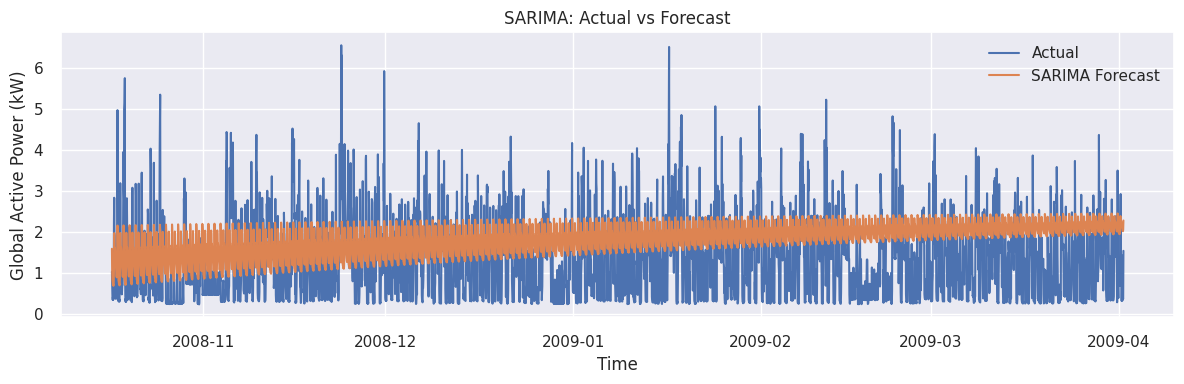

In [ ]:
# =====================================
# 6. SARIMA model (univariate baseline)
# =====================================

# Use training portion of the hourly target for SARIMA
y_full = df_hourly[target_col].dropna()
split_idx_sarima = int(len(y_full) * 0.8)
y_train_sarima = y_full.iloc[:split_idx_sarima]
y_test_sarima = y_full.iloc[split_idx_sarima:]

# Note: these orders are just a reasonable starting point; you can tune them
sarima_order = (2, 1, 2)     # (p,d,q)
seasonal_order = (1, 0, 1, 24)  # (P,D,Q,s) with daily seasonality at hourly frequency

sarima_model = SARIMAX(
    y_train_sarima,
    order=sarima_order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results = sarima_model.fit(disp=False)
print(sarima_results.summary())

# Forecast for length of test set
sarima_forecast = sarima_results.forecast(steps=len(y_test_sarima))

# Align indexes
sarima_forecast.index = y_test_sarima.index

# Evaluation
sarima_mae = mean_absolute_error(y_test_sarima, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(y_test_sarima, sarima_forecast))
sarima_r2 = r2_score(y_test_sarima, sarima_forecast)

print("SARIMA MAE:", sarima_mae)
print("SARIMA RMSE:", sarima_rmse)
print("SARIMA R2:", sarima_r2)

# Plot SARIMA forecast vs actual
plt.figure(figsize=(12, 4))
plt.plot(y_test_sarima.index, y_test_sarima, label="Actual")
plt.plot(sarima_forecast.index, sarima_forecast, label="SARIMA Forecast")
plt.title("SARIMA: Actual vs Forecast")
plt.ylabel("Global Active Power (kW)")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()

Random Forest MAE: 0.42413003154347156
Random Forest RMSE: 0.607626579038176
Random Forest R2: 0.6004770402477226


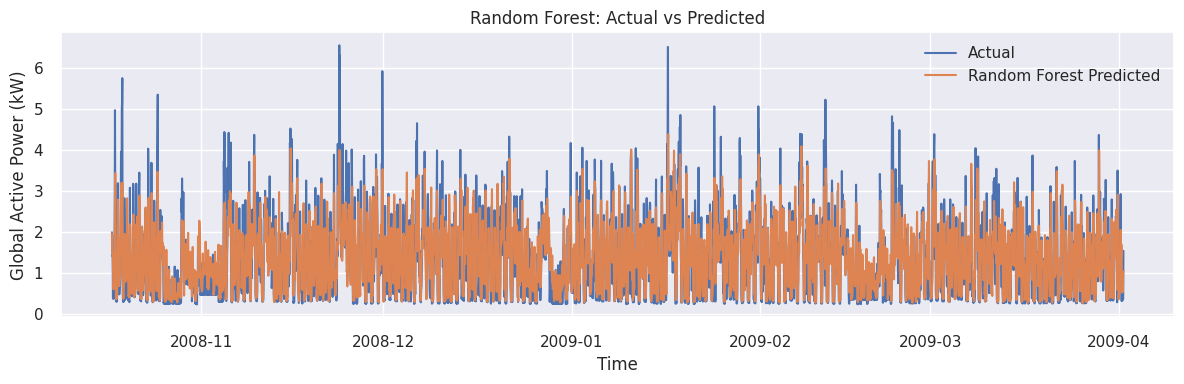

In [ ]:
# =========================================
# 7. Random Forest regression model
# =========================================

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest MAE:", rf_mae)
print("Random Forest RMSE:", rf_rmse)
print("Random Forest R2:", rf_r2)

# Plot RF predictions vs actual
plt.figure(figsize=(12, 4))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, rf_pred, label="Random Forest Predicted")
plt.title("Random Forest: Actual vs Predicted")
plt.ylabel("Global Active Power (kW)")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()

HGBR MAE: 0.41429135117933386
HGBR RMSE: 0.5969575990028703
HGBR R2: 0.6143838743517931


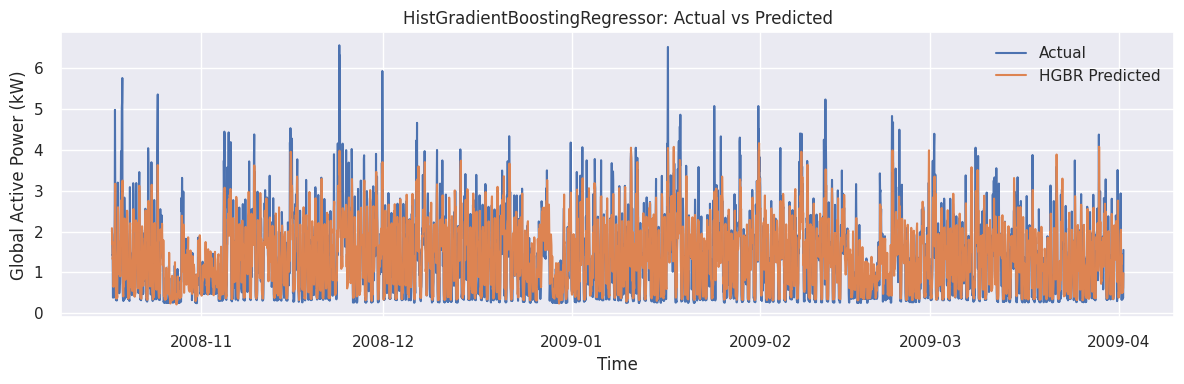

In [ ]:
# =================================================
# 8. Gradient Boosting regression (HGBR baseline)
# =================================================

gbr_model = HistGradientBoostingRegressor(
    max_depth=None,
    learning_rate=0.1,
    max_iter=300,
    random_state=42
)

gbr_model.fit(X_train, y_train)

gbr_pred = gbr_model.predict(X_test)

gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_pred))
gbr_r2 = r2_score(y_test, gbr_pred)

print("HGBR MAE:", gbr_mae)
print("HGBR RMSE:", gbr_rmse)
print("HGBR R2:", gbr_r2)

# Plot HGBR predictions vs actual
plt.figure(figsize=(12, 4))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, gbr_pred, label="HGBR Predicted")
plt.title("HistGradientBoostingRegressor: Actual vs Predicted")
plt.ylabel("Global Active Power (kW)")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# =================================
# 9. Compare model performances
# =================================

results = pd.DataFrame({
    "Model": ["SARIMA", "Random Forest", "HistGradientBoosting"],
    "MAE": [sarima_mae, rf_mae, gbr_mae],
    "RMSE": [sarima_rmse, rf_rmse, gbr_rmse],
    "R2": [sarima_r2, rf_r2, gbr_r2]
})

results


,Model,MAE,RMSE,R2
0,SARIMA,0.861427,1.027137,-0.141921
1,Random Forest,0.424130,0.607627,0.600477
2,HistGradientBoosting,0.414291,0.596958,0.614384
